based on: https://medium.com/geekculture/converting-yolo-v7-to-tensorflow-lite-for-mobile-deployment-ebc1103e8d1e


In [3]:
!pip --quiet install onnx onnxruntime onnxsim
!pip install onnx-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/yolov7/

/content/drive/MyDrive/yolov7


In [ ]:
!python export.py --weights runs/train/yolov7-first-gen-binary/weights/best.pt --grid --end2end --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640 --max-wh 640

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='runs/train/yolov7-first-gen-binary/weights/best.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=640, topk_all=100, iou_thres=0.65, conf_thres=0.35, device='cpu', simplify=False, include_nms=False, fp16=False, int8=False)
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Starting TorchScript export with torch 1.13.1+cu116...
/content/drive/MyDrive/yolov7/models/y

In [6]:
# Inference for ONNX model
#Importing necessary libraries.
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import matplotlib.pyplot as plt
cuda = False
w = "/content/drive/MyDrive/yolov7/runs/train/yolov7-first-gen-binary/weights/best.onnx"
#Loading image for testing.
img = cv2.imread('/content/drive/MyDrive/obj/1.JPG')


In [7]:
#Loading the ONNX inference session.
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

#Name of the classes according to class indices.
names = ['unripe','ripe']

#Creating random colors for bounding box visualization.
colors = {name:[random.randint(0, 255) for _ in range(2)] for i,name in enumerate(names)}

In [8]:
import os
folder = '/content/drive/MyDrive/obj'

colors = {'unripe': (0, 255, 0), 'ripe': (255, 0, 0)} # Define colors for each object
# Change 'object1' and 'object2' to the actual names of the objects you are detecting

plt.figure(figsize = (20,10))
for i, img in enumerate(os.listdir(folder)):
    img_file = folder + f'/{img}'
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocessing the image for prediction.
    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255
    im.shape

    # Getting onnx graph input and output names.
    outname = [i.name for i in session.get_outputs()]
    inname = [i.name for i in session.get_inputs()]
    inp = {inname[0]:im}

    # Running inference using session.
    outputs = session.run(outname, inp)[0]

    ori_images = [img.copy()]

    # Visualizing bounding box prediction.
    for j, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(outputs):
        image = ori_images[int(batch_id)]
        box = np.array([x0, y0, x1, y1])
        box -= np.array(dwdh*2)
        box /= ratio
        box = box.round().astype(np.int32).tolist()
        cls_id = int(cls_id)
        score = round(float(score), 3)
        name = names[cls_id]
        color = colors[name] # Get the color for the object

        # Draw the bounding box with the color
        cv2.rectangle(image, box[:2], box[2:], color, 2)
 
    
    plt.subplot(1, len(os.listdir(folder)), i+1) # Add subplot for each image
    plt.imshow(ori_images[0])
    plt.tight_layout()
    plt.axis('off')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!onnx-tf convert -i /content/yolov7/yolov7.onnx -o /content/

2023-03-31 23:11:34.777390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/onnx-tf", line 5, in <module>
    from onnx_tf.cli import main
  File "/usr/local/lib/python3.9/dist-packages/onnx_tf/__init__.py", line 1, in <module>
    from . import backend
  File "/usr/local/lib/python3.9/dist-packages/onnx_tf/backend.py", line 21, in <module>
    import tensorflow as tf
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/__init__.py", line 105, in <module>
    from tensorflow.python.platform import test
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/platform/test.py", line 20, in <module>
    from tensorflow.python.framework import test_util as _test_util
  File "/usr/local/lib/python3.9/dist-pa

In [ ]:
!onnx-tf convert -i /content/drive/MyDrive/yolov7/runs/train/yolov7-first-gen-binary/weights/best.onnx -o /content/

2023-03-31 23:12:22.010894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2023-03-31 23:12:25,133 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2023-03-31 23:12:25.962374: E tensorflow/compiler/xla/stream_executor/

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('/content/')
tflite_model = converter.convert()

with open('/content/yolov7_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/yolov7_model.tflite")





def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

#Name of the classes according to class indices.
names = ['unripe','ripe']

#Creating random colors for bounding box visualization.
#Load and preprocess the image.
img = cv2.imread('/content/drive/MyDrive/obj/1.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255


#Allocate tensors.
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], im)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])


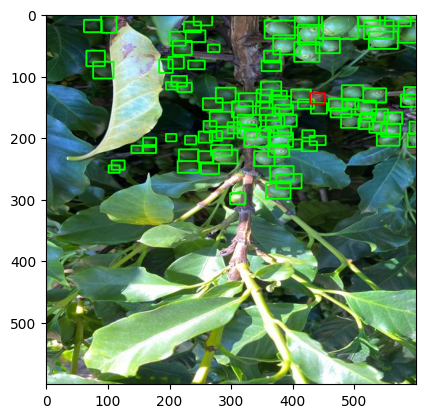

In [ ]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(output_data):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
plt.imshow(ori_images[0])

In [ ]:
mv /content/model_deployment /content/drive/MyDrive/

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/model_deployment/yolov7_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[ 0.0000000e+00  8.6809280e+01  3.7137448e+02  9.4105957e+01
   3.7758804e+02  1.0000000e+00  4.7941476e-01]
 [ 0.0000000e+00  4.5278870e+01  1.6735710e+02  5.2491486e+01
   1.7357368e+02  1.0000000e+00  4.7328317e-01]
 [ 0.0000000e+00  4.7823276e+02  1.0422187e+02  4.8515970e+02
   1.1026754e+02  1.0000000e+00  4.6585149e-01]
 [ 0.0000000e+00  6.0780542e+02  1.8093773e+02  6.1452173e+02
   1.8760777e+02  1.0000000e+00  4.6184078e-01]
 [ 0.0000000e+00  3.1643751e+01  1.7243681e+02  3.8002274e+01
   1.7937096e+02  1.0000000e+00  4.3595913e-01]
 [ 0.0000000e+00  5.7415015e+02  4.4629553e+02  5.8058594e+02
   4.5274640e+02  1.0000000e+00  3.9209142e-01]
 [ 0.0000000e+00  5.9223199e+02  2.1278333e+02  5.9838080e+02
   2.1969592e+02  1.0000000e+00  3.6997062e-01]
 [ 0.0000000e+00  5.8194214e+02  2.1449847e+02  5.8865027e+02
   2.2097421e+02  1.0000000e+00  3.6844179e-01]
 [ 0.0000000e+00  3.7562625e+02  4.2224112e+02  3.8188187e+02
   4.2875613e+02  1.0000000e+00  3.5614946e-01]
 [ 0.00000

In [ ]:
cd /content/drive/MyDrive/yolov7

/content/drive/MyDrive/yolov7


In [ ]:
# Clone the YOLOv7 repository


# Download the pretrained model
# Install dependencies
!pip install -r requirements.txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install ngrok -q
!pip install pyngrok -q

In [ ]:
import threading
from pyngrok import ngrok
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ngrok.connect(5000)

<NgrokTunnel: "http://be7f-34-91-191-234.ngrok.io" -> "http://localhost:5000">

In [ ]:
cd /content/drive/MyDrive/yolov7

/content/drive/MyDrive/yolov7


In [ ]:
!pip install flask -q 
!pip install opencv-python -q

import threading
import numpy as np
from flask import Flask, request, jsonify
from models.experimental import attempt_load
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.torch_utils import select_device, time_synchronized
import torch
import cv2
from flask_ngrok import run_with_ngrok


# Load YOLOv7 model
device = select_device('')
model = attempt_load(w, map_location=device)
imgsz = check_img_size(640, s=model.stride.max())
model.to(device).eval()

# Create Flask app
app = Flask(__name__)
run_with_ngrok(app)   


# Define API endpoint for object detection
@app.route('/', methods=['POST'])
def detect():
    # Get image file from request
    image_file = request.files.get('image')
    if image_file is None:
        return jsonify({'error': 'no image file'})

    # Read and preprocess image
    image = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img0 = image.copy()
    img = torch.from_numpy(image).to(device)
    img = img.permute(2, 0, 1).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Run inference and get predictions
    pred = model(img)[0]
    pred = non_max_suppression(pred)

    # Process predictions and draw bounding boxes
    det = pred[0]
    if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()
        for *xyxy, conf, cls in reversed(det):
            label = f'{model.names[int(cls)]} {conf:.2f}'
            cv2.rectangle(img0, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (255, 0, 0), 2)
            cv2.putText(img0, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Encode and return the image with bounding boxes
    _, img_encoded = cv2.imencode('.jpg', cv2.cvtColor(img0, cv2.COLOR_RGB2BGR))
    response = img_encoded.tobytes()
    return response, 200

# Start the Flask server
if __name__ == '__main__':
    app.run()


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://8792-34-91-191-234.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [01/Apr/2023 01:08:06] "GET / HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2023 01:08:06] "GET /favicon.ico HTTP/1.1" 404 -
